In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from kafka import KafkaConsumer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import time 
from scipy.spatial.distance import mahalanobis,euclidean

In [2]:
# Given a initialization dataset, split it into normal lists and abnormal lists of different subsets.

class Data_Helper(object):
    
    def __init__(self, path,training_set_size,step_num,batch_num,training_data_source,log_path):
        self.path = path
        self.step_num = step_num
        self.batch_num = batch_num
        self.training_data_source = training_data_source
        self.training_set_size = training_set_size
        
        

        self.df = pd.read_csv(self.path).iloc[:self.training_set_size,:]
            
        print("Preprocessing...")
        
        self.sn,self.vn1,self.vn2,self.tn,self.va,self.ta,self.va_labels = self.preprocessing(self.df,log_path)
        assert min(self.sn.size,self.vn1.size,self.vn2.size,self.tn.size,self.va.size,self.ta.size) > 0, "Not enough continuous data in file for training, ended."+str((self.sn.size,self.vn1.size,self.vn2.size,self.tn.size,self.va.size,self.ta.size))
           
        # data seriealization
        t1 = self.sn.shape[0]//step_num
        t2 = self.va.shape[0]//step_num
        t3 = self.vn1.shape[0]//step_num
        t4 = self.vn2.shape[0]//step_num
        t5 = self.tn.shape[0]//step_num
        t6 = self.ta.shape[0]//step_num
        
        self.sn_list = [self.sn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t1)]
        self.va_list = [self.va[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
        self.vn1_list = [self.vn1[step_num*i:step_num*(i+1)].as_matrix() for i in range(t3)]
        self.vn2_list = [self.vn2[step_num*i:step_num*(i+1)].as_matrix() for i in range(t4)]
        
        self.tn_list = [self.tn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t5)]
        self.ta_list = [self.ta[step_num*i:step_num*(i+1)].as_matrix() for i in range(t6)]
        
        self.va_label_list =  [self.va_labels[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
        
        print("Ready for training.")
        

    
    def preprocessing(self,df,log_path):
        
        #scaling
        label = df.iloc[:,-1]
        scaler = MinMaxScaler()
        scaler.fit(df.iloc[:,:-1])
        cont = pd.DataFrame(scaler.transform(df.iloc[:,:-1]))
        data = pd.concat((cont,label),axis=1)
        
        # split data according to window length
        # split dataframe into segments of length L, if a window contains mindestens one anomaly, then this window is anomaly wondow
        L = self.step_num 
        n_list = []
        a_list = []
        temp = []
        a_pos= []
        
        windows = [data.iloc[w*self.step_num:(w+1)*self.step_num,:] for w in range(data.index.size//self.step_num)]
        for win in windows:
            label = win.iloc[:,-1]
            if label[label!="normal"].size == 0:
                n_list += [i for i in win.index]
            else:
                a_list += [i for i in win.index]

        normal = data.iloc[np.array(n_list),:-1]
        anomaly = data.iloc[np.array(a_list),:-1]
        print("Info: Initialization set contains %d normal windows and %d abnormal windows."%(normal.shape[0],anomaly.shape[0]))

        a_labels = data.iloc[np.array(a_list),-1]
        
        # split into subsets
        tmp = normal.index.size//self.step_num//10 
        assert tmp > 0 ,"Too small normal set %d rows"%normal.index.size
        sn = normal.iloc[:tmp*5*self.step_num,:]
        vn1 = normal.iloc[tmp*5*self.step_num:tmp*8*self.step_num,:]
        vn2 = normal.iloc[tmp*8*self.step_num:tmp*9*self.step_num,:]
        tn = normal.iloc[tmp*9*self.step_num:,:]
        
        tmp_a = anomaly.index.size//self.step_num//2 
        va = anomaly.iloc[:tmp_a*self.step_num,:] if tmp_a !=0 else anomaly
        ta = anomaly.iloc[tmp_a*self.step_num:,:] if tmp_a !=0 else anomaly
        a_labels = a_labels[:va.index.size]
        
        print("Local preprocessing finished.")
        print("Subsets contain windows: sn:%d,vn1:%d,vn2:%d,tn:%d,va:%d,ta:%d\n"%(sn.shape[0]/self.step_num,vn1.shape[0]/self.step_num,vn2.shape[0]/self.step_num,tn.shape[0]/self.step_num,va.shape[0]/self.step_num,ta.shape[0]/self.step_num))
        
        f = open(log_path,'a')
        
        f.write("Info: Initialization set contains %d normal windows and %d abnormal windows.\n"%(normal.shape[0],anomaly.shape[0]))
        f.write("Subsets contain windows: sn:%d,vn1:%d,vn2:%d,tn:%d,va:%d,ta:%d\n"%(sn.shape[0]/self.step_num,vn1.shape[0]/self.step_num,vn2.shape[0]/self.step_num,tn.shape[0]/self.step_num,va.shape[0]/self.step_num,ta.shape[0]/self.step_num))
        f.close()
        
        return sn,vn1,vn2,tn,va,ta,a_labels

In [3]:
class Conf_EncDecAD_KDD99(object):
    
    def __init__(self, training_data_source = "file", optimizer=None, decode_without_input=False):
        
        self.batch_num = 8
        self.hidden_num = 35
        self.step_num = 30
        self.input_root ="C:/Users/Bin/Desktop/Thesis/dataset/http_new.csv"
        self.iteration = 300
        self.modelpath_root = "C:/Users/Bin/Desktop/Thesis/models/http_8_35_30/"
        self.modelmeta = self.modelpath_root + "_"+str(self.batch_num)+"_"+str(self.hidden_num)+"_"+str(self.step_num)+"_.ckpt.meta"
        self.modelpath_p = self.modelpath_root + "_"+str(self.batch_num)+"_"+str(self.hidden_num)+"_"+str(self.step_num)+"_para.ckpt"
        self.modelmeta_p = self.modelpath_root + "_"+str(self.batch_num)+"_"+str(self.hidden_num)+"_"+str(self.step_num)+"_para.ckpt.meta"
        self.decode_without_input =  False
        
        self.log_path = "C:/Users/Bin/Desktop/Thesis/models/http_8_35_30/log.txt"
        self.training_set_size = self.step_num*1000
        # import dataset
        # The dataset is divided into 6 parts, namely training_normal, validation_1,
        # validation_2, test_normal, validation_anomaly, test_anomaly.
       
        self.training_data_source = training_data_source
        data_helper = Data_Helper(self.input_root,self.training_set_size,self.step_num,self.batch_num,self.training_data_source,self.log_path)
        
        self.sn_list = data_helper.sn_list
        self.va_list = data_helper.va_list
        self.vn1_list = data_helper.vn1_list
        self.vn2_list = data_helper.vn2_list
        self.tn_list = data_helper.tn_list
        self.ta_list = data_helper.ta_list
        self.data_list = [self.sn_list, self.va_list, self.vn1_list, self.vn2_list, self.tn_list, self.ta_list]
        
        self.elem_num = data_helper.sn.shape[1]
        self.va_label_list = data_helper.va_label_list 
        
        
        f = open(self.log_path,'a')
        f.write("Batch_num=%d\nHidden_num=%d\nwindow_length=%d\ntraining_used_#windows=%d\n"%(self.batch_num,self.hidden_num,self.step_num,self.training_set_size//self.step_num))
        f.close()

In [4]:
class EncDecAD(object):

    def __init__(self, hidden_num, inputs, is_training, optimizer=None, reverse=True, decode_without_input=False):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        
        self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
        self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
        if is_training == True:
            self._enc_cell = tf.nn.rnn_cell.DropoutWrapper(self._enc_cell, input_keep_prob=0.8, output_keep_prob=0.8)
            self._dec_cell = tf.nn.rnn_cell.DropoutWrapper(self._dec_cell, input_keep_prob=0.8, output_keep_prob=0.8)
        
        self.is_training = is_training
        
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2],name="input_")
        
        with tf.variable_scope('encoder',reuse = tf.AUTO_REUSE):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder',reuse =tf.AUTO_REUSE) as vs:
         
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,self.elem_num], dtype=tf.float32))
 
            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32))

            dec_state = self.enc_state
            dec_input_ = tf.ones(tf.shape(inputs[0]),dtype=tf.float32)
            dec_outputs = []
            
            for step in range(len(inputs)):
                if step > 0:
                    vs.reuse_variables()
                (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                dec_outputs.append(dec_input_)
                # use real input as as input of decoder ***********************************
                tmp = -(step+1) 
                dec_input_ = inputs[tmp]
                
            if reverse:
                dec_outputs = dec_outputs[::-1]

            self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2],name="output_")
            self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_),name="loss")
        
        def check_is_train(is_training):
            def t_ (): return tf.train.AdamOptimizer().minimize(self.loss,name="train_")
            def f_ (): return tf.train.AdamOptimizer(1/math.inf).minimize(self.loss)
            is_train = tf.cond(is_training, t_, f_)
            return is_train
        self.train = check_is_train(is_training)

In [5]:
class Parameter_Helper(object):
    
    def __init__(self, conf):
        self.conf = conf
       
        
    def mu_and_sigma(self,sess,input_, output_,p_input, p_is_training):

        err_vec_list = []
        
        ind = list(np.random.permutation(len(self.conf.vn1_list)))
        
        while len(ind)>=self.conf.batch_num:
            data = []
            for _ in range(self.conf.batch_num):
                data += [self.conf.vn1_list[ind.pop()]]
            data = np.array(data,dtype=float)
            data = data.reshape((self.conf.batch_num,self.conf.step_num,self.conf.elem_num))

            (_input_, _output_) = sess.run([input_, output_], {p_input: data, p_is_training: False})
            abs_err = abs(_input_ - _output_)
            err_vec_list += [abs_err[i] for i in range(abs_err.shape[0])]
            

        # new metric
        err_vec_array = np.array(err_vec_list).reshape(-1,self.conf.elem_num)
        
        # for multivariate data, anomaly score is squared mahalanobis distance

        mu = np.mean(err_vec_array,axis=0)
        sigma = np.cov(err_vec_array.T)

        print("Got parameters mu and sigma.")
        
        return mu, sigma
        

        
    def get_threshold(self,mu,sigma,sess,input_, output_,p_input, p_is_training):

            normal_score = []
            for count in range(len(self.conf.vn2_list)//self.conf.batch_num):
                normal_sub = np.array(self.conf.vn2_list[count*self.conf.batch_num:(count+1)*self.conf.batch_num]) 
                (input_n, output_n) = sess.run([input_, output_], {p_input: normal_sub,p_is_training : False})

                err_n = abs(input_n-output_n).reshape(-1,self.conf.step_num,self.conf.elem_num)
                for window in range(self.conf.batch_num):
                        for t in range(self.conf.step_num):
                            normal_score.append(mahalanobis(err_n[window,t],mu,sigma))
                            

                    
            abnormal_score = []
            '''
            if have enough anomaly data, then calculate anomaly score, and the 
            threshold that achives best f1 score as divide boundary.
            otherwise estimate threshold through normal scores
            '''
            print(len(self.conf.va_list))
            
            if len(self.conf.va_list) < self.conf.batch_num: # not enough anomaly data for a single batch
                threshold = max(normal_score) * 2
                print("Not enough large va set, estimated threshold by normal data.")
                
            else:
            
                for count in range(len(self.conf.va_list)//self.conf.batch_num):
                    abnormal_sub = np.array(self.conf.va_list[count*self.conf.batch_num:(count+1)*self.conf.batch_num]) 
                    va_lable_list = np.array(self.conf.va_label_list[count*self.conf.batch_num:(count+1)*self.conf.batch_num]) 
                    va_lable_list = va_lable_list.reshape(self.conf.batch_num,self.conf.step_num)
                    
                    (input_a, output_a) = sess.run([input_, output_], {p_input: abnormal_sub,p_is_training : False})
                    err_a = abs(input_a-output_a).reshape(-1,self.conf.step_num,self.conf.elem_num)
                    for window in range(self.conf.batch_num):
                        for t in range(self.conf.step_num):
                            s = mahalanobis(err_a[window,t],mu,sigma)
                            
                            if va_lable_list[window,t] == "normal":
                                normal_score.append(s)
                            else:
                                abnormal_score.append(s)
                
                upper = np.median(np.array(abnormal_score))
                lower = np.median(np.array(normal_score)) 
                scala = 20
                delta = (upper-lower) / scala
                candidate = lower
                threshold = 0
                result = 0
                
                def evaluate(threshold,normal_score,abnormal_score):
#                    pd.Series(normal_score).to_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/normal.csv",index=None)
#                    pd.Series(abnormal_score).to_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/abnormal.csv",index=None)
                    
                    beta = 0.5
                    tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
                    fp = len(abnormal_score)-tp
                    fn = np.array(normal_score)[np.array(normal_score)>threshold].size
                    tn = len(normal_score)- fn
                    
                    if tp == 0: return 0
                    
                    P = tp/(tp+fp)
                    R = tp/(tp+fn)
                    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
                    return fbeta 
                
                for _ in range(scala):
                    r = evaluate(candidate,normal_score,abnormal_score)
                    if r > result:
                        result = r 
                        threshold = candidate
                    candidate += delta 
            
            print("Threshold: ",threshold)

            return threshold

  
  


In [6]:
class EncDecAD_Train(object):
    
    def __init__(self,training_data_source='file'):
        start_time = time.time()
        conf = Conf_EncDecAD_KDD99(training_data_source=training_data_source)
        

        batch_num = conf.batch_num
        hidden_num = conf.hidden_num
        step_num = conf.step_num
        elem_num = conf.elem_num
        
        iteration = conf.iteration
        modelpath_root = conf.modelpath_root
        modelpath = conf.modelpath_p
        decode_without_input = conf.decode_without_input
        
        patience = 20
        patience_cnt = 0
        min_delta = 0.0001
        
        
        #************#
        # Training
        #************#
        
        p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num),name = "p_input")
        p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]
        
        p_is_training = tf.placeholder(tf.bool,name= "is_training_")
        
        ae = EncDecAD(hidden_num, p_inputs, p_is_training , decode_without_input=False)
        
        graph = tf.get_default_graph()
        gvars = graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        assign_ops = [graph.get_operation_by_name(v.op.name + "/Assign") for v in gvars]
        init_values = [assign_op.inputs[1] for assign_op in assign_ops]    
            
        
        print("Training start.")
        with tf.Session() as sess:
            saver = tf.train.Saver()
            
            
            sess.run(tf.global_variables_initializer())
            input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
            output_ = graph.get_tensor_by_name("decoder/output_:0")

            loss = []
            val_loss = []
            sn_list_length = len(conf.sn_list)
            tn_list_length = len(conf.tn_list)
            
            for i in range(iteration):
                #training set
                snlist = conf.sn_list[:]
                tmp_loss = 0
                for t in range(sn_list_length//batch_num):
                    data =[]
                    for _ in range(batch_num):
                        data.append(snlist.pop())
                    data = np.array(data)
                    (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data,p_is_training : True})
                    tmp_loss += loss_val
                l = tmp_loss/(sn_list_length//batch_num)
                loss.append(l)
                
                #validation set
                tnlist = conf.tn_list[:]
                tmp_loss_ = 0
                for t in range(tn_list_length//batch_num):
                    testdata = []
                    for _ in range(batch_num):
                        testdata.append(tnlist.pop())
                    testdata = np.array(testdata)
                    (loss_val,ein,aus) = sess.run([ae.loss,input_,output_], {p_input: testdata,p_is_training :False})
                    tmp_loss_ += loss_val
                tl = tmp_loss_/(tn_list_length//batch_num)
                val_loss.append(tl)
                print('Epoch %d: Loss:%.3f, Val_loss:%.3f' %(i, l,tl))
                if i == 100:
                    break;
             
        
            plt.plot(loss,label="Train")
            plt.plot(val_loss,label="val_loss")
            plt.legend()
            plt.show()
            
        
            
            
            # mu & sigma & threshold

            para = Parameter_Helper(conf)
            mu, sigma = para.mu_and_sigma(sess,input_, output_,p_input, p_is_training)
            threshold = para.get_threshold(mu,sigma,sess,input_, output_,p_input, p_is_training)
            
#            test = EncDecAD_Test(conf)
#            test.test_encdecad(sess,input_,output_,p_input,p_is_training,mu,sigma,threshold,beta = 0.5)
            
            c_mu = tf.constant(mu,dtype=tf.float32,name = "mu")
            c_sigma = tf.constant(sigma,dtype=tf.float32,name = "sigma")
            c_threshold = tf.constant(threshold,dtype=tf.float32,name = "threshold")
            print("Saving model to disk...")
            save_path = saver.save(sess, conf.modelpath_p)
            print("Model saved accompany with parameters and threshold in file: %s" % save_path)
            
            print("--- Initialization time: %s seconds ---" % (time.time() - start_time))
            
            f = open(conf.log_path,'a')
            f.write("Early stopping at epoch %d\n"%i)
            f.write("Model saved accompany with parameters and threshold in file: %s" % save_path)
            f.write("--- Initialization time: %s seconds ---" % (time.time() - start_time))
            f.close()

Preprocessing...
Info: Initialization set contains 29460 normal windows and 540 abnormal windows.
Local preprocessing finished.
Subsets contain windows: sn:490,vn1:294,vn2:98,tn:100,va:9,ta:9

Ready for training.
Training start.
Epoch 0: Loss:0.180, Val_loss:0.033
Epoch 1: Loss:0.027, Val_loss:0.014
Epoch 2: Loss:0.015, Val_loss:0.009
Epoch 3: Loss:0.011, Val_loss:0.007
Epoch 4: Loss:0.009, Val_loss:0.006
Epoch 5: Loss:0.008, Val_loss:0.005
Epoch 6: Loss:0.007, Val_loss:0.004
Epoch 7: Loss:0.006, Val_loss:0.004
Epoch 8: Loss:0.005, Val_loss:0.003
Epoch 9: Loss:0.005, Val_loss:0.003
Epoch 10: Loss:0.004, Val_loss:0.002
Epoch 11: Loss:0.004, Val_loss:0.002
Epoch 12: Loss:0.004, Val_loss:0.002
Epoch 13: Loss:0.003, Val_loss:0.002
Epoch 14: Loss:0.003, Val_loss:0.002
Epoch 15: Loss:0.003, Val_loss:0.002
Epoch 16: Loss:0.003, Val_loss:0.002
Epoch 17: Loss:0.003, Val_loss:0.001
Epoch 18: Loss:0.003, Val_loss:0.001
Epoch 19: Loss:0.003, Val_loss:0.001
Epoch 20: Loss:0.003, Val_loss:0.001
Epoc

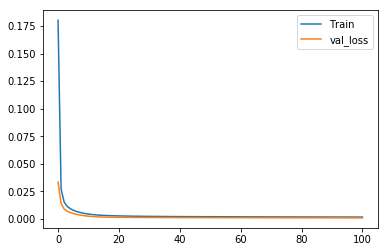

Got parameters mu and sigma.
9
Threshold:  0.0549761145839
Saving model to disk...
Model saved accompany with parameters and threshold in file: C:/Users/Bin/Desktop/Thesis/models/http_8_35_30/_8_35_30_para.ckpt
--- Initialization time: 195.33389258384705 seconds ---


In [7]:
if __name__=="__main__":

    EncDecAD_Train()


    